In [1]:
""" Rayleigh Bénard convection data. """
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


RB_CONVECTION_GRID = {
    'rayleigh': [1e6, 1e7, 1e8, 1e9, 1e10],
    'prandtl': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
    'dT': [0.2, 0.4, 0.6, 0.8, 1.0],  # the vertical delta in buoyancy at initialization
    'seed': [40,41,42,43,44,45,46,47,48,49],  # the random seed of initialization
}

DATA_PATH = Path("/mnt/home/polymathic/ceph/the_well/2D/rayleigh_benard/data/")

def filename(rayleigh, prandtl):
    """ Hdf5 file name corresponding to one set of coefficients. """
    filename = f"Rayleigh{rayleigh:.1e}_Prandtl{prandtl:.1e}".replace('.','_').replace('-','m').replace('+','p')
    return filename + ".h5"

def read_data(rayleigh, prandtl, dT, seed):
    """ Read the data from the hdf5 file.
    
    Parameters
    ----------
    rayleigh : float
        The Rayleigh number (PDE coefficient).
    prandtl : float
        The Prandtl number (PDE coefficient).
    dT : float
        The vertical delta in buoyancy (initial condition).
    seed : int
        The random seed (initial condition).
    """
    filepath = DATA_PATH / filename(rayleigh, prandtl)
    if (
        rayleigh not in RB_CONVECTION_GRID['rayleigh'] or 
        prandtl not in RB_CONVECTION_GRID['prandtl'] or 
        dT not in RB_CONVECTION_GRID['dT'] or 
        seed not in RB_CONVECTION_GRID['seed']
    ):
        raise ValueError(f"Invalid coefficients. The available coefficients are: {RB_CONVECTION_GRID}")
    # find the right index in the batch
    idx_dT = RB_CONVECTION_GRID['dT'].index(dT)
    idx_seed = RB_CONVECTION_GRID['seed'].index(seed)
    idx = idx_seed + idx_dT * len(RB_CONVECTION_GRID['seed'])
    # load data
    hf = h5py.File(filepath, 'r')
    xt = np.stack([
        hf['tasks']['buoyancy'][idx,...],
        hf['tasks']['pressure'][idx,...],
        hf['tasks']['vorticity'][idx,...],
        hf['tasks']['unknown'][idx,:,0,...],
        hf['tasks']['unknown'][idx,:,1,...],
    ], axis=1)
    hf.close()
    return xt

def ploter_im(x):
    """ Plot a single frame of the data. """
    fig, axes = plt.subplots(5, 1, figsize=(12,14))
    def plot_one_axis(ax, y, vmax=None):
        if vmax is None:
            vmax = np.max(np.abs(y)) + 1e-6
        norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        im = ax.imshow(y.T[::-1,:], cmap='RdBu_r', norm=norm)
        cbaxes = ax.inset_axes([0.01, 1.02, 0.99, 0.04])
        cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
        cbar.ax.tick_params(axis='x', direction='out', labeltop=True, labelbottom=False, bottom=False, top=True)
    axes[0].set_title('buoyancy')
    axes[1].set_title('pressure')
    axes[2].set_title('vorticity')
    axes[3].set_title('u1')
    axes[4].set_title('u2')
    plot_one_axis(axes[0], x[0,:,:], vmax=1.0)
    plot_one_axis(axes[1], x[1,:,:])
    plot_one_axis(axes[2], x[2,:,:])
    plot_one_axis(axes[3], x[3,:,:])
    plot_one_axis(axes[4], x[4,:,:])
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(hspace=0.4)

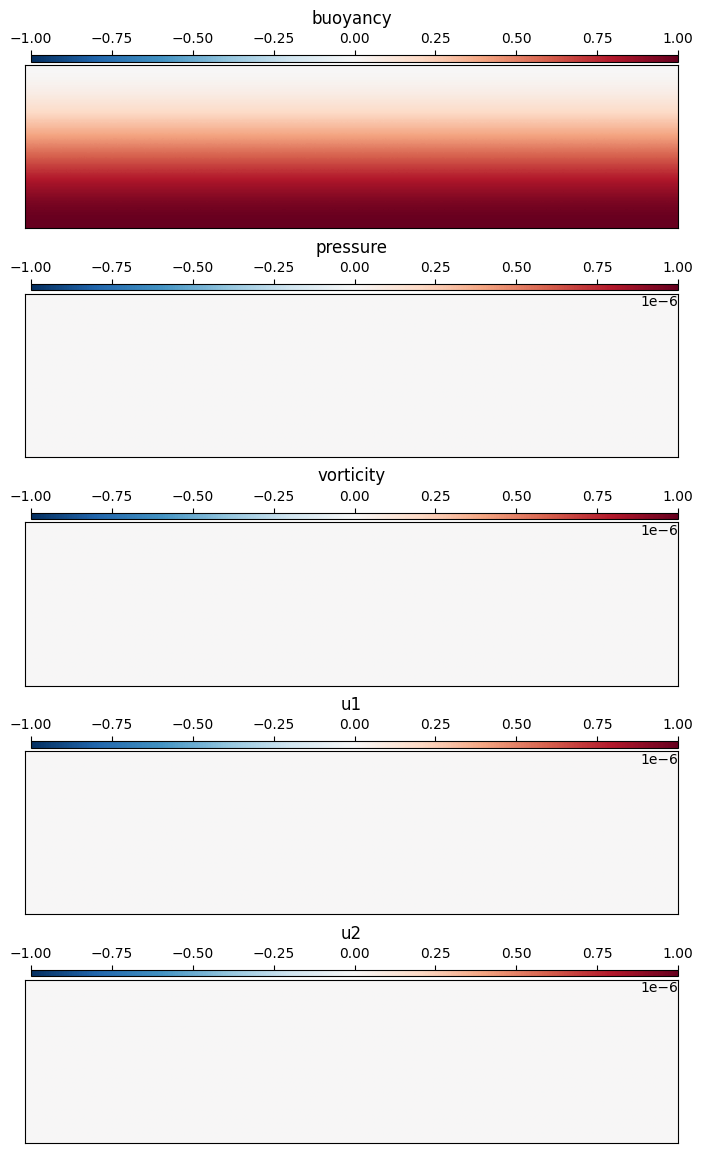

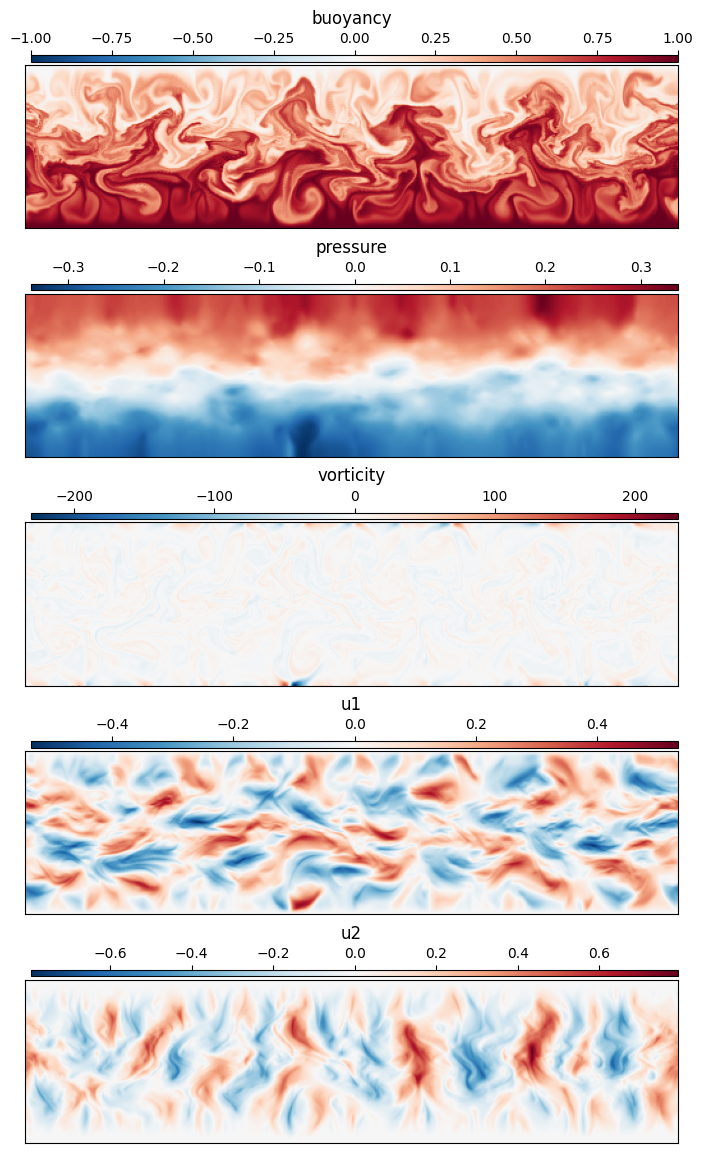

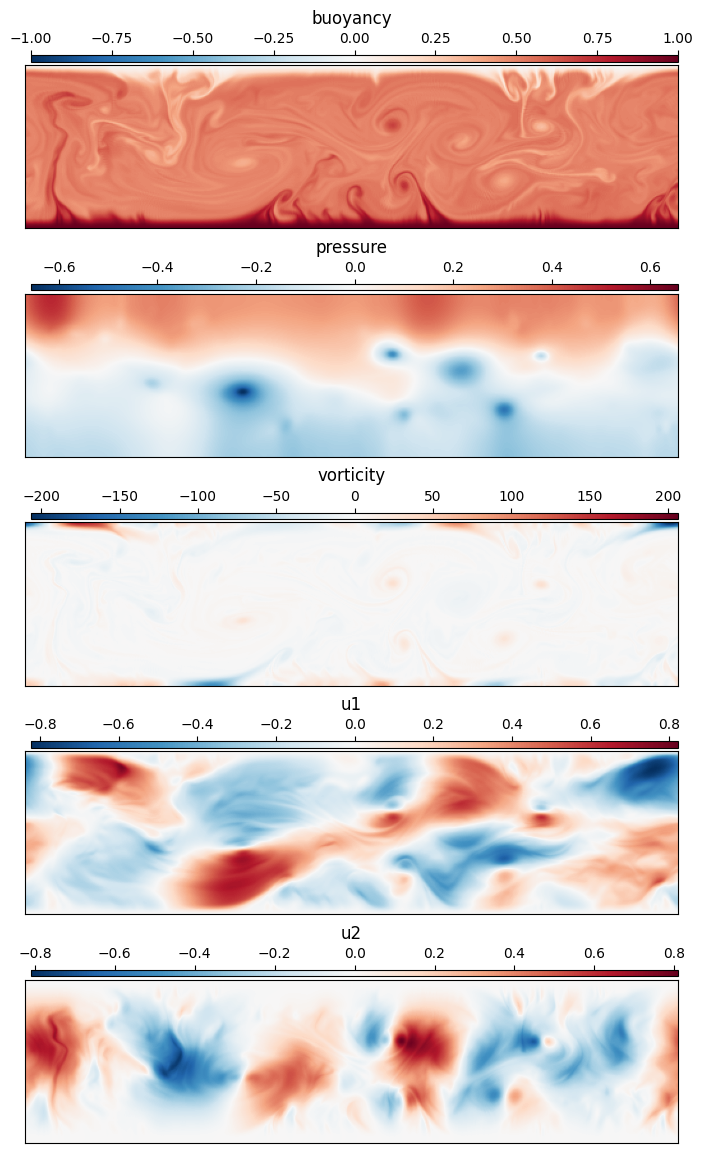

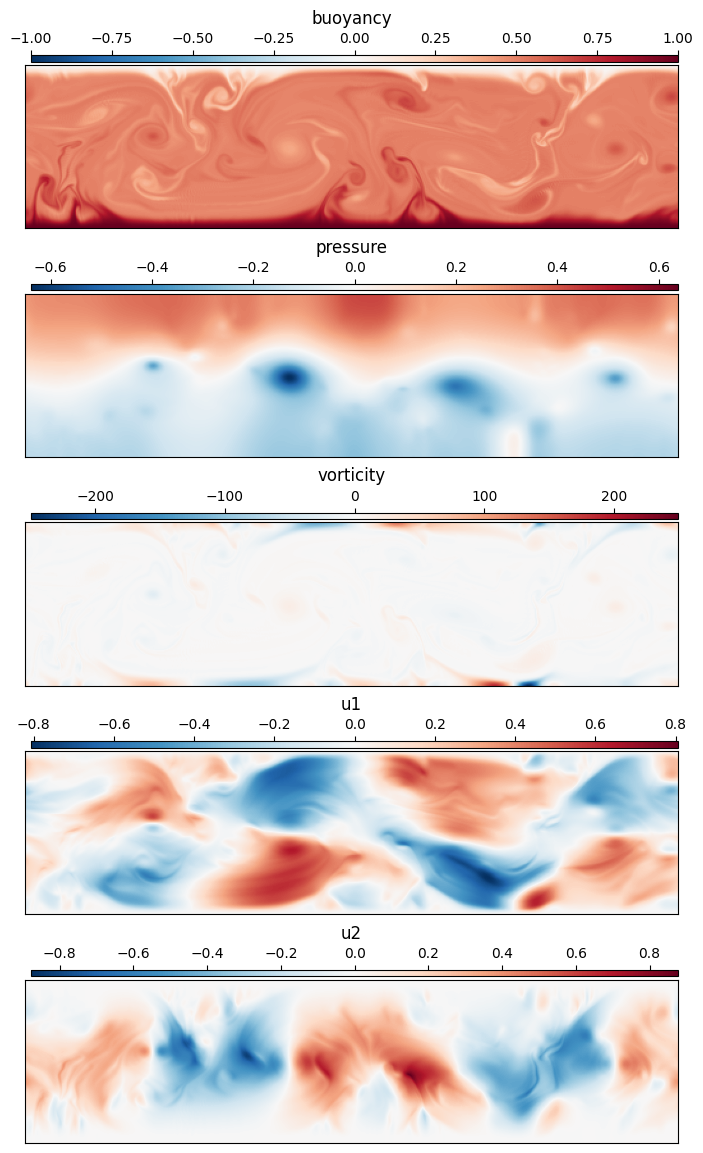

In [4]:
################################
rayleigh = 1e9
prandtl = 1.0
dT = 1.0
seed = 40
################################

# load file
x = read_data(rayleigh, prandtl, dT, seed)
T, C, H, W = x.shape

# plot the data
for idx_time in range(0, T, T//4):
    ploter_im(x[idx_time, :, :, :])